# Machine Learning for option pricing
## Homework 1 : Princig american option using CRR model

**Student**:  *BAHOUS Youness*

In this first homework, we will implement the Cox-Ross-Rubinstein (CRR) model to price an American option. The CRR model is a binomial tree model that is used to price options. The model is based on the assumption that the underlying asset follows a binomial distribution

In [201]:
# Libraries

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom


# Params and style
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 100

params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7 }

Here I define the parameters of the model and the number of steps in the binomial tree.

In [202]:
T = 1 # Maturity in years
r = 0.01 # Annual risk-free rate
K = 100 # Strike price
S0 = 100 # Initial stock price
sigma = 0.2# Annual volatility
N = 20
dt = T/N # Time step

Using **Cox-Ross-Rubinstein** model, we have:

- u : the up factor
- d : the down factor
- p : the (Historical) probability of going up

$$ u = e^{\sigma \sqrt{\Delta t}} $$
$$ d = e^{-\sigma \sqrt{\Delta t}} $$
$$ p = \frac{1}{2}(1 + (r - \frac{1}{2}\sigma^2)\frac{\sqrt{\Delta t}}{\sigma}) $$

In [203]:
u = np.exp(sigma*np.sqrt(dt)) # Up movement
print(f"Up movement: {u:.2f}")
d = 1/u # Down movement
print(f"Down movement: {d:.2f}")
p = 0.5*(1 + (r - 0.5*sigma**2)*np.sqrt(dt)/sigma) # Risk-neutral probability
print(f"Probability of up movement: {p:.2f}")

Up movement: 1.05
Down movement: 0.96
Probability of up movement: 0.49


In [204]:
# States here is just for plotting
states = []
for n in range(N+1):
    states.append(np.arange(n+1))

# Asset price at each state
asset = []
for n, xn in enumerate(states):
    asset.append(S0*u**xn*d**(n-xn))



In the following, I calculate the option price and the snell envelope at each node of the binomial tree.

In [205]:
# Payoff of the option
option = np.zeros((N+1, N+1))
snell = np.zeros((N+1, N+1))

snell[-1] = np.maximum(0, K - asset[-1])

# Option payoff at each state
for n in range(N-1, -1, -1):
    for i in range(n+1):
        option[n, i] = np.exp(-r*dt)*(p*snell[n+1, i+1] + (1-p)*snell[n+1, i])
        intrinsic = max(0, K - asset[n][i])
        snell[n][i] = max(option[n][i], intrinsic)
print(f'Option price: {snell[0,0]*np.exp(r*dt):.2f}')

Option price: 7.45


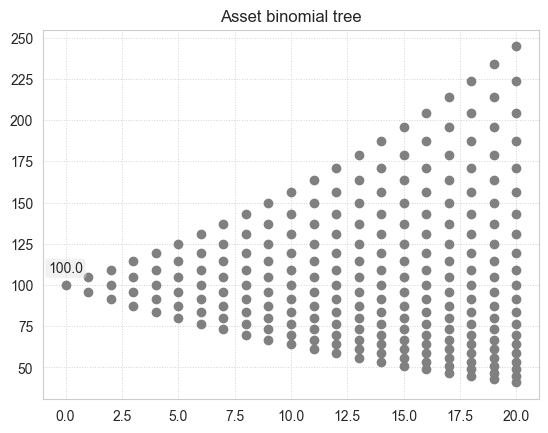

In [206]:
fig, ax = plt.subplots()
ax.grid(**params_grid)
ax.set_title('Asset binomial tree')
for n in range(N+1):
    for v, z in zip(snell[n], asset[n]):
        ax.scatter(n, z, color='grey', marker='o')
        if (N <= 10 or n == 0): 
            ax.annotate(f'{z:.1f}', xy = (n, z), xytext = (0, 12),
                        textcoords = 'offset points', ha = 'center', va = 'center',
                        bbox = dict(boxstyle = 'round,pad=0.2', fc = 'lightgrey', alpha = 0.3))

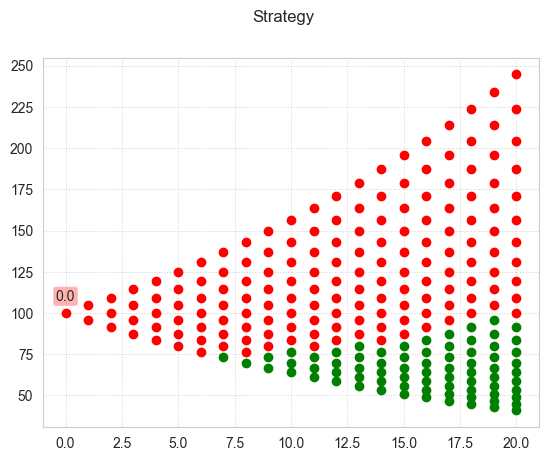

In [207]:
stop = [snell[n] == option[n] for n in range(N+1)] # Stopping times
colors = {1: 'red', 0: 'green'} # Red for stopping, green for continuing

fig, ax = plt.subplots()
fig.suptitle('Strategy')
ax.grid(**params_grid)
for n in range(N+1):
    for v, z, s in zip(snell[n], asset[n], stop[n]):
        ax.scatter(n, z, color=colors[s], marker='o')
        if (N <= 10 or n == 0): 
            ax.annotate(f'{max(0,K-z):.1f}', xy = (n, z), xytext = (0, 12),
                        textcoords = 'offset points', ha = 'center', va = 'center',
                        bbox = dict(boxstyle = 'round,pad=0.2', fc = colors[s], alpha = 0.3))

# Monte Carlo simulation for price computation

In [214]:
# Transition probabilities
P = [np.zeros((len(states[n]), len(states[n+1]))) for n in range(N)]
for n in range(N):
    for i, x in enumerate(states[n]):
        for j, y in enumerate(states[n+1]):
            if y == x+1: P[n][i][j] = p
            if y == x: P[n][i][j] = 1-p

In [215]:
path = np.zeros(N+1, dtype=int)
for n in range(1, N+1): 
    path[n] = np.random.choice(np.arange(P[n-1].shape[1]),1, p=P[n-1][path[n-1]])[0]
    if (stop[n][path[n]] == 1): break # on sort et la valeur n est figée 
    
# gains path
gains = [option[n][path[n]] for n in range(N+1)]
print(f"Les prix à chaque étape sont: {gains}.")
# et la valeur de sortie de cette trajectoire
print(f"Le payoff final est {gains[n]}.")

Les prix à chaque étape sont: [7.442745108194297, 9.429127500396513, 11.740044737610415, 14.358884856770693, 17.246948818019966, 20.34528217398017, 23.581103237129092, 26.8300460528693, 30.026694486068358, 33.08486781865219, 36.009288572009986, 38.80580656252038, 41.48001575839919, 44.037265469500674, 46.48267104772043, 48.82112411940444, 51.0573023702324, 53.195678902148394, 55.24053118105598, 57.19594959317581, 0.0].
Le payoff final est 9.429127500396513.


In [216]:
M = int(1e5)
gains_opt = np.zeros(M)
path = np.zeros(N+1, dtype=int)
for j in range(M):
    for n in range(1, N+1): 
        path[n] = np.random.choice(np.arange(P[n-1].shape[1]), 1, p=P[n-1][path[n-1]])[0]
        if (stop[n][path[n]] == 1): break # on sort et la valeur n est figée 
    gains_opt[j] = option[n][path[n]]  

m = np.mean(gains_opt)
ic_size = 1.96 * np.sqrt(np.var(gains_opt, ddof=1) / M) 
print(f"La valeur de l'estimateur avec {M} scénarios est: {m:.4}, et la variance estimée est {np.var(gains_opt):.4}.")
print(f"La vraie valeur se trouve dans l'intervalle [{m-ic_size:.4}, {m+ic_size:.4}] avec proba 0.95 (M = {M}).")

La valeur de l'estimateur avec 100000 scénarios est: 7.467, et la variance estimée est 4.018.
La vraie valeur se trouve dans l'intervalle [7.455, 7.479] avec proba 0.95 (M = 100000).
